# DNA meth level

In [1]:
import subprocess
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = 'Arial'
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

In [2]:
### get_methylation_levels.py -m $methfi -b ${beddirPrefix}_${feature}.bed -p 100 -o ${j}_${feature}.txt -c 1
def scan_meth_level_split2bins(meth_scan, name, capture_regions_file, samGbed_files, labels, resolution=100, left_span=2000, right_span=2000, origin_len = 1) :
    cmd = f'''awk '{{print $1"\\t"$2-{left_span}-{resolution >> 1}"\\t"$3+{right_span}+{resolution >> 1}"\\t"$4"\\t"$5"\\t"$6}}' {capture_regions_file} > capture_regions.bed '''
    print(subprocess.check_output(cmd, shell=True).decode(), end='')
    capture_points = int((left_span + right_span) / resolution + 1) if (left_span+right_span) > 0 else int(origin_len / resolution + 1)
    capture_regions_file = 'capture_regions.bed'
    for index,samGbed in enumerate(samGbed_files) :
        meth_scan_cmd = f'/mnt/Storage/home/wangyiman/bin/utilities/get_methylation_levels.py -m {samGbed} -p {capture_points} -b {capture_regions_file} -o signal_{name}_siteprof{index+1}.txt'
        if meth_scan :
#             print(meth_scan_cmd)
            print(subprocess.check_output(meth_scan_cmd.split()).decode(), end='')
    
    xticks = np.arange(-left_span, right_span + resolution, resolution) if (left_span+right_span) > 0 else np.arange(0, origin_len + resolution, resolution)
    signal = {}
    for index, (samGbed, label) in enumerate(zip(samGbed_files, labels)):
        signal[label] = pd.read_csv(f'signal_{name}_siteprof{index+1}.txt',
                                    sep=',',
                                    header=None,
                                    index_col=None,
                                    names=xticks)     
    return signal    

In [3]:
stage_dict = {
    'EarlyEmbryogenesis': ['2cell','8cell','Morula','ICM',],
    'PGCsDevelopment': ['E10.5','E13.5_female','E13.5_male',],
    'Spermatogenesis': ['US','DS','PS','RS',],
    'RetinalDevelopment': ['E14.5','E17.5','P0','P3','P7','P10','P14','P21',],
    'HeartDevelopment': ['E10.5','E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0',],
    'LiverDevelopment': ['E11.5','E12.5','E13.5','E14.5','E15.5','E16.5','P0']
}

In [5]:
os.chdir('/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/CHMOrganization/Universal_specific/Features/ChromatinStates/Cavalli_Cell2017_ABcompartment_5tissue/CHM_intersect_table/')
signal_AB_dict = {}
for end in ['5end', '3end', 'body'] :
    signal_AB_dict[end] = {}
    for compart in ['A', 'B'] :
        bed_fi = f'intersectOnly_UniversalCHM_5tissue_{compart}.{end}.bed' if end != 'body' else f'intersectOnly_UniversalCHM_5tissue_{compart}.bed'
        meth_scan = True if end != 'body' else True
#             resolution = 100 if end == 'body' else 5000
        left_span = 0 if end != '5end' else 100000
        right_span = 0 if end != '3end' else 100000
        origin_len = 0 if end != 'body' else 5000 # average Universal CHM length
        signal_AB_dict[end][compart] = scan_meth_level_split2bins(
            meth_scan = meth_scan,
            name = f'DNAMeth_around_CHM_{compart}_{end}',
            capture_regions_file = bed_fi,
            resolution = 100,
            left_span = left_span,
            right_span = right_span,
            origin_len = origin_len,
            samGbed_files = [f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/CellStateTransition/{process}/PreparedBeforeCallCHM/{stage}.methyl.sam.G.bed' for process in stage_dict.keys() for stage in stage_dict[process]],
            labels = [f'{process}_{stage}_DNAmeth' for process in stage_dict.keys() for stage in stage_dict[process]],
        )

In [8]:
signal_AB_concat_dict = {}
for span in [50000, 100000] :
    signal_AB_concat_dict[span] = {}
    for i,label in enumerate([f'{process}_{stage}_DNAmeth' for process in stage_dict.keys() for stage in stage_dict[process]]) :        
        signal_AB_concat_dict[span][label] = {}
        for compart in ['A', 'B'] :
            signal_AB_concat_dict[span][label][compart] = pd.concat([signal_AB_dict['5end'][compart][label][np.arange(-span, 0, 100)], 
                                                                                signal_AB_dict['body'][compart][label], 
                                                                                signal_AB_dict['3end'][compart][label][np.arange(100, span+100, 100)]], axis = 1)
            body_len = signal_AB_dict['body'][compart][label].columns[-1] - signal_AB_dict['body'][compart][label].columns[0]
            signal_AB_concat_dict[span][label][compart].columns = np.arange(-span, 0, 100).tolist() + signal_AB_dict['body'][compart][label].columns.tolist() + (np.arange(100, span+100, 100) + body_len).tolist() 
                
signal_AB_concat_dict[span][label][compart]

,-100000,-99900,-99800,-99700,-99600,-99500,-99400,-99300,-99200,-99100,...,104100,104200,104300,104400,104500,104600,104700,104800,104900,105000
0,0.714286,NaN,NaN,0.000000,0.066667,NaN,0.684211,NaN,NaN,NaN,...,NaN,0.578947,NaN,0.563107,0.333333,0.600000,0.595745,NaN,NaN,0.761905
1,NaN,NaN,0.611111,0.520000,0.343750,NaN,0.600000,NaN,NaN,NaN,...,NaN,0.321429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,0.571429,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.642857,NaN,0.857143,NaN,0.250000,NaN,0.583333,NaN
3,0.483871,NaN,NaN,0.687500,NaN,0.578947,NaN,NaN,NaN,NaN,...,0.250000,0.571429,0.500000,0.833333,0.500000,0.375000,0.562500,0.70000,NaN,0.923077
4,NaN,NaN,0.434783,NaN,0.745455,NaN,0.705882,0.705882,0.545455,0.800000,...,NaN,0.818182,0.600000,0.666667,NaN,0.789474,0.821429,0.72000,0.884615,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941,NaN,0.176471,NaN,NaN,NaN,NaN,0.407407,NaN,NaN,NaN,...,0.846154,0.909091,NaN,0.727273,NaN,0.800000,0.500000,0.80000,0.895833,0.890000
942,NaN,NaN,NaN,NaN,NaN,NaN,0.659574,NaN,NaN,NaN,...,NaN,NaN,0.666667,NaN,NaN,0.933333,0.733333,NaN,0.382353,0.848485
943,NaN,NaN,0.500000,0.700000,NaN,NaN,NaN,0.585366,0.400000,0.666667,...,0.636364,NaN,NaN,NaN,0.764706,NaN,NaN,NaN,NaN,NaN
944,0.727273,0.758621,NaN,0.235294,0.818182,NaN,NaN,NaN,0.750000,NaN,...,0.800000,NaN,0.847826,NaN,0.652174,NaN,0.727273,NaN,0.761905,NaN


In [9]:
colors = ['#C490C6', '#90ADC6']

In [10]:
signal_AB_concat_dict[span][label][compart][-100000].dropna().mean()

0.672832431418627

In [11]:
stage_3_dict = {
 'EarlyEmbryogenesis': ['2cell', '8cell', 'ICM'],
 'PGCsDevelopment': ['E10.5', 'E13.5_female', 'E13.5_male'],
 'Spermatogenesis': ['US', 'DS', 'RS'],
 'RetinalDevelopment': ['E14.5', 'P0', 'P21'],
 'HeartDevelopment': ['E10.5', 'E13.5', 'P0'],
 'LiverDevelopment': ['E11.5', 'E14.5', 'P0']
}

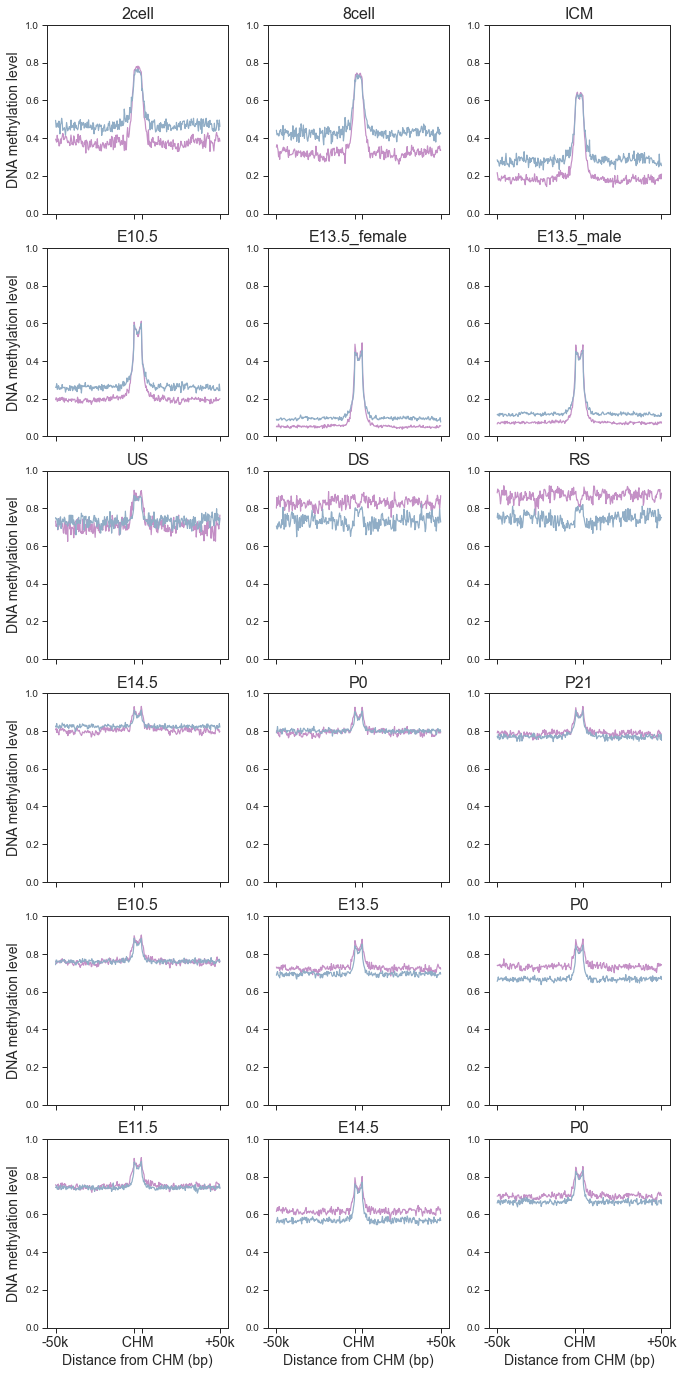

In [13]:
from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 16,
                             'axes.labelsize': 14,
                             'xtick.labelsize': 14,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 8
                         }):
    
    for span in [50000] :    
        fig, axes = plt.subplots(6, 3, figsize=(6.4 * 1.5, 4.8 * 4), sharey = False, sharex = True, tight_layout = True)  
        for a,process in enumerate(stage_dict.keys()) :
            for b,stage in enumerate(stage_3_dict[process]) : 
                ax = axes[a, b]
                label = f'{process}_{stage}_DNAmeth'
                for j,compart in enumerate(['A', 'B']) :
                    x = signal_AB_concat_dict[span][label][compart].columns
                    xnew = np.linspace(x.min(), x.max(), 300) 
                    spl = make_interp_spline(x, signal_AB_concat_dict[span][label][compart].mean(), k = 1)
                    signal_smooth = spl(xnew)
                    ax.plot(xnew, signal_smooth, label=compart, color=colors[j])

                ax.set_xticks([-span, 0, 5000, 5000+span])
                ax.set_xticklabels([f'-{str(span)[:-3]}k', "  CHM", "", f"+{str(span)[:-3]}k"])

                if a == (len(stage_dict.keys()) - 1) :
                    ax.set_xlabel('Distance from CHM (bp)')

                if b == 0 :
                    ax.set_ylabel('DNA methylation level')
                ax.set_title(f'{stage}')

                ax.set_ylim(0,1)

        fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_line_DNAmeth_3stages_UniversalCHM_overlap_ABcompart_{str(span)[:-3]}k_5tissue_consistent.pdf', transparent=True)        


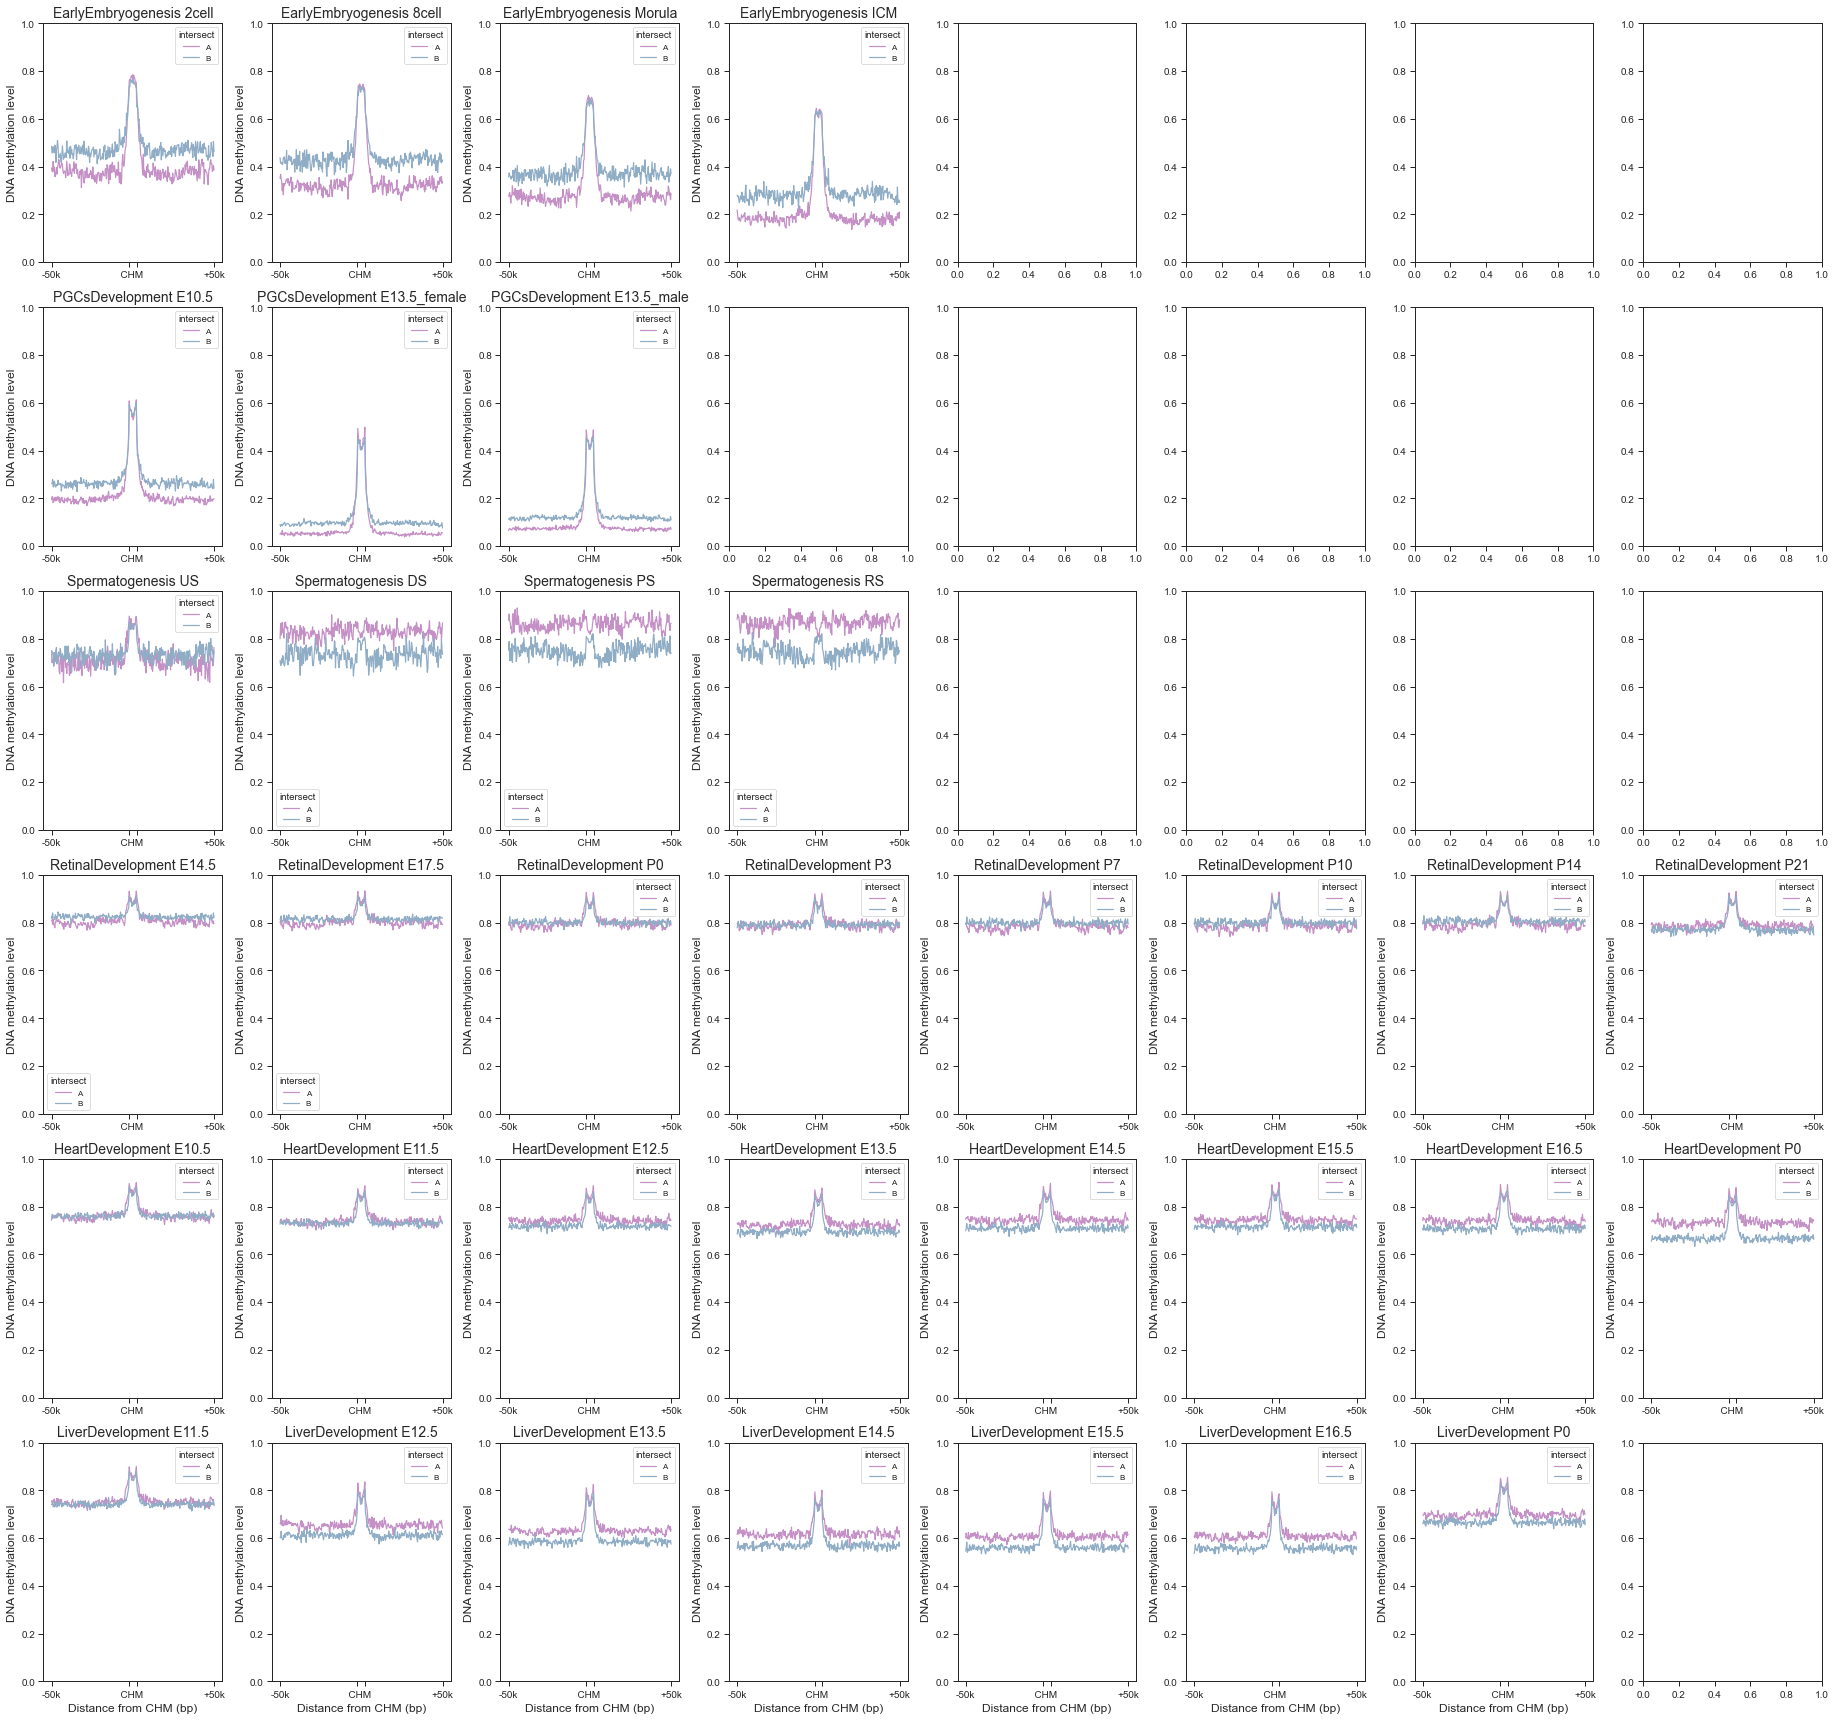

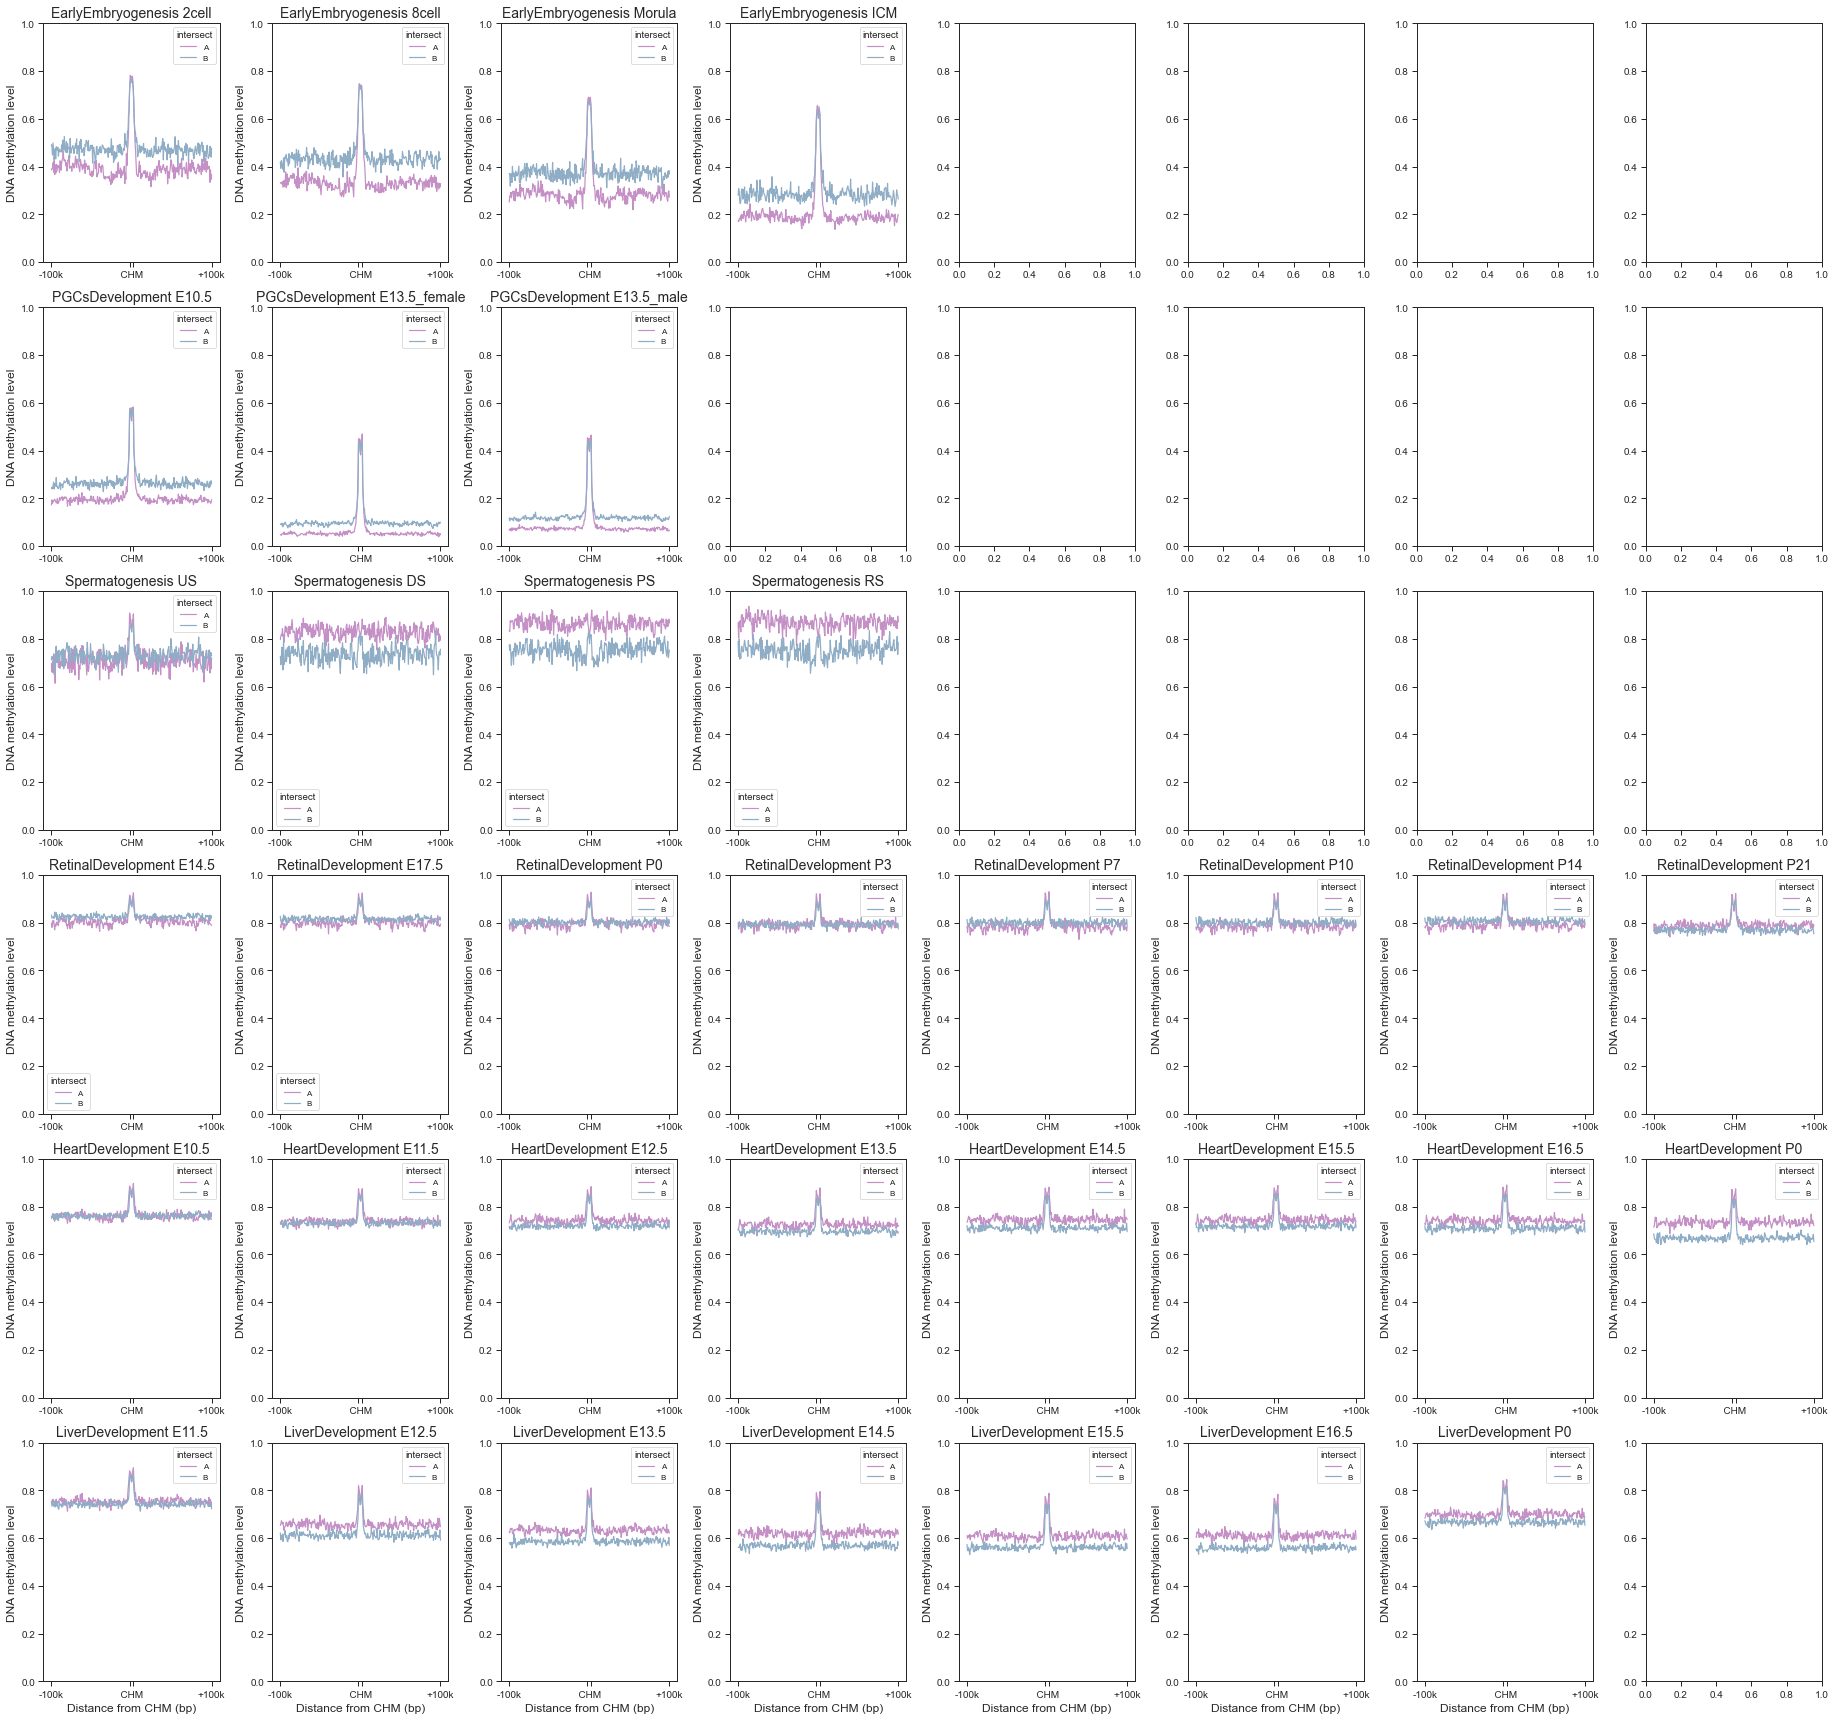

In [11]:
### not used


from scipy.interpolate import make_interp_spline, BSpline
with sns.axes_style('white', rc={
        'xtick.bottom': True,
        'ytick.left': True
}), sns.plotting_context('paper',
                         rc={
                             'axes.titlesize': 14,
                             'axes.labelsize': 12,
                             'xtick.labelsize': 10,
                             'ytick.labelsize': 10,
                             'legend.fontsize': 8
                         }):
    
#     for span in [10000, 50000, 100000, 500000, 1000000, 2000000] :    
    for span in [50000, 100000] :    
#         for cell_type in ['ES', 'NPC', 'CN'] :
#         for cell_type in ['ES', 'NPC', 'CN', 'intersect'] :
        for cell_type in ['intersect'] :
            fig, axes = plt.subplots(6, 8, figsize=(6.4 * 4, 4.8 * 5), sharey = False, sharex = False, tight_layout = True)  
    #         fig.tight_layout(rect=[0, 0.025, 1, .97])
    #         fig.suptitle(f'A/B compartment data from {cell_type}', size = 15)
    #         for i,label in enumerate([f'{process}_{stage}_H3K9me3' for process in stage_dict.keys() for stage in stage_dict[process]]) :
            for a,process in enumerate(stage_dict.keys()) :
                for b,stage in enumerate(stage_dict[process]) : 
    #                 ax = axes[int(i/6), i%6]
                    ax = axes[a, b]
                    label = f'{process}_{stage}_DNAmeth'
#                     for j,compart in enumerate(['totallyInside_A', 'totallyInside_B']) :
                    for j,compart in enumerate(['overlap_A', 'overlap_B']) :
                        x = signal_AB_concat_dict[span][cell_type][label][compart].columns
                        xnew = np.linspace(x.min(), x.max(), 300) 
                        spl = make_interp_spline(x, signal_AB_concat_dict[span][cell_type][label][compart].mean(), k = 3)
                        signal_smooth = spl(xnew)
        #                 ax.plot(xnew, signal_smooth, label=compart, color=color_dict[label.split('_')[0]][j])
                        ax.plot(xnew, signal_smooth, label=compart, color=colors[j])

#                     if b == (len(stage_dict[process])-1) :
#                     ax.set_yscale('log', base=2)
                    h, l = ax.get_legend_handles_labels()
                    ax.legend(h, ['A', 'B'], title=cell_type)

                    ax.set_xticks([-span, 0, 5000, 5000+span])
#                     ax.set_xticklabels([f'-{str(span)[:-3]}k', f'-{str(int(span/2))[:-3]}k', " CHM", "", f"+{str(int(span/2))[:-3]}k", f"+{str(span)[:-3]}k"])
                    ax.set_xticklabels([f'-{str(span)[:-3]}k', "  CHM", "", f"+{str(span)[:-3]}k"])

                    if a == (len(stage_dict.keys()) - 1) :
                        ax.set_xlabel('Distance from CHM (bp)')
                
                    ax.set_ylabel('DNA methylation level')
                    ax.set_title(f'{process} {stage}')
                    
                    ax.set_ylim(0,1)

            fig.savefig(f'/mnt/Storage/home/wangyiman/CHMsInOtherContexts/figures/make13_line_DNAmeth_UniversalCHM_overlap_ABcompart_{cell_type}_{str(span)[:-3]}k_5tissue.pdf', transparent=True)        


In [10]:
h